In [1]:
import pandas as pd
#from hmmlearn import hmm
import numpy as np
import seaborn as sns
from scipy.stats import norm
import itertools
import matplotlib.pyplot as plt
#from hmmlearn.hmm import GMMHMM
from  sklearn.metrics import mean_squared_error as mse
from sklearn.utils import class_weight
from astropy.io import fits
import matplotlib.pyplot as plt
import os, sys

from sklearn.metrics import confusion_matrix,accuracy_score, f1_score
from keras.regularizers import l2
from keras.activations import tanh
from keras.models import Sequential
from keras.layers import *
from keras.losses import categorical_crossentropy,binary_crossentropy
from keras.optimizers import SGD
from keras.callbacks import LearningRateScheduler
from keras import optimizers
from keras import backend as K
from time import time
from random import shuffle,seed
from sklearn.metrics import classification_report
from keras.regularizers import l2
from keras.callbacks import LearningRateScheduler
from keras.callbacks import EarlyStopping
from keras.backend import eval
import warnings
warnings.filterwarnings('ignore')

Using TensorFlow backend.


In [2]:
dirpath = os.getcwd().split("code")[0]+"code/"
sys.path.append(dirpath)
from evaluation import calculate_metrics, plot_ROC

In [3]:
import keras
from keras.callbacks import Callback,ModelCheckpoint, ReduceLROnPlateau
class Metrics(Callback):
    def on_train_begin(self, logs={}):
        self.val_f1s = []

    def on_epoch_end(self, batch, logs={}):
        predict = np.squeeze(self.model.predict_classes(self.validation_data[0]))
        targ = np.squeeze(self.validation_data[1])
        f1s = f1_score(targ, predict, average='macro')
        self.val_f1s.append(f1s)
        print(" - val_f1: %f " %(f1s))
        return

import tensorflow as tf
def binary_focal_loss(gamma=2., alpha=.25):
    """
    Binary form of focal loss.
      FL(p_t) = -alpha * (1 - p_t)**gamma * log(p_t)
      where p = sigmoid(x), p_t = p or 1 - p depending on if the label is 1 or 0, respectively.
    References:
        https://arxiv.org/pdf/1708.02002.pdf
    Usage:
     model.compile(loss=[binary_focal_loss(alpha=.25, gamma=2)], metrics=["accuracy"], optimizer=adam)
    """
    def binary_focal_loss_fixed(y_true, y_pred):
        """
        :param y_true: A tensor of the same shape as `y_pred`
        :param y_pred:  A tensor resulting from a sigmoid
        :return: Output tensor.
        """
        pt_1 = tf.where(tf.equal(y_true, 1), y_pred, tf.ones_like(y_pred))
        pt_0 = tf.where(tf.equal(y_true, 0), y_pred, tf.zeros_like(y_pred))

        epsilon = K.epsilon()
        # clip to prevent NaN's and Inf's
        pt_1 = K.clip(pt_1, epsilon, 1. - epsilon)
        pt_0 = K.clip(pt_0, epsilon, 1. - epsilon)

        return -K.sum(alpha * K.pow(1. - pt_1, gamma) * K.log(pt_1)) \
               -K.sum((1 - alpha) * K.pow(pt_0, gamma) * K.log(1. - pt_0))

    return binary_focal_loss_fixed

def train_model(aux_model, x_train, y_train, x_val, y_val, e=25, BS=128, focal=False,alpha=0.6,save_f='best_mod.hdf5'):
    if focal:
        aux_model.compile(loss=binary_focal_loss(alpha=alpha, gamma=2),optimizer='Adam',metrics=['accuracy'])
    else:
        aux_model.compile(loss='binary_crossentropy',optimizer='Adam',metrics=['accuracy'])
    
    calls = []
    metrics = Metrics()
    calls.append(metrics)
    mcp_save = ModelCheckpoint(save_f, save_best_only=True, monitor='val_loss', mode='min')
    calls.append(mcp_save)
    reduce_lr = ReduceLROnPlateau(monitor='val_loss', mode ='min',factor=0.2,patience=10, min_lr=0.001)
    if not focal:
        calls.append(reduce_lr)
    hist=aux_model.fit(x_train, y_train, batch_size=BS, epochs=e, verbose=1, validation_split=0.1,#validation_data=(x_val,y_val),
                      callbacks=calls)
    
    plt.figure(figsize=(12,5))
    plt.plot(hist.history['loss'],label="train_loss")
    plt.plot(hist.history['val_loss'],label="val_loss")
    plt.title("Model Loss BCE CNN") 
    plt.ylabel('Loss')
    plt.xlabel('Epochs')
    plt.legend(loc="upper right")
    plt.show()

    plt.figure(figsize=(12,5))
    plt.plot(hist.history['acc'],label="Train accuracy" )
    plt.plot(hist.history['val_acc'],label="Val accuracy" )
    plt.title("Model Accuracy BCE CNN") 
    plt.ylabel('Loss')
    plt.xlabel('Epochs')
    plt.legend(loc="upper right")
    plt.show()
    
    plt.figure(figsize=(12,5))
    if not focal:
        plt.plot(hist.history['val_loss'],label="loss" )
    plt.plot(hist.history['val_acc'],label="accuracy" )
    plt.plot(metrics.val_f1s,label="F1" )
    plt.ylabel("Metric")
    plt.xlabel('Epochs')
    plt.title("Test set/val")
    plt.legend(loc="upper left")
    plt.show()
    
    
    #print("Best f1 macro trough iters %f on %d "%(np.max(metrics.val_f1s),np.argmax(metrics.val_f1s)))

    #predichos=aux_model.predict_classes(x_val)
    #calculate_metrics(y_val, predichos,'[VAL] Confusion Matrix 50 epochs CNN + reverse LC')

In [4]:
df_aux = pd.read_csv("../../KOI_Data/kepler_dataset.csv")
labels = (df_aux["NExScI Disposition"] == "CONFIRMED").values*1
labels.shape

(8054,)

In [5]:
fold = "../../KOI_Data/"
df_sets = pd.read_csv(fold+"/koi_sets.csv") 
mask_train = (df_sets["Set"] == "Train").values
mask_test = (df_sets["Set"] == "Test").values
mask_unlabeled = (df_sets["Set"] == "Unlabeled").values
df_sets.head()

,KOI Name,Set
0,K00889.01,Train
1,K01009.01,Train
2,K07621.01,Test
3,K06252.01,Test
4,K00958.01,Unlabeled


In [6]:
df_meta = pd.read_csv(fold+"/koi_metadata.csv")
df_meta_train = df_meta[mask_train]
df_meta_test = df_meta[mask_test]
df_meta_unb = df_meta[mask_unlabeled]

df_meta_train.head()

,KOI Name,NExScI Disposition,Kepler Name,Period,Time of Transit Epoch,First Transit Time (BJD),Impact Parameter,Duration,Transit Depth,r/R,...,Teff,log(g),Metallicity,Stellar Radius,Stellar Mass,Max single event sigma,Max Multievent sigma,Transit Model SNR,KOI count,Transit Number
0,K00889.01,CONFIRMED,Kepler-75 b,8.884923,169.991686,2455002.992,0.069,2.07004,16053.4,0.114,...,5332.0,4.500,-0.08,0.843,0.821,61.291,474.021,388.2,1,153
1,K01009.01,FALSE POSITIVE,NaN,5.092465,357.535940,2455190.536,0.161,3.65900,254.0,0.014,...,5037.0,4.547,-0.20,0.751,0.727,3.648,15.175,17.1,1,225
7,K07622.01,FALSE POSITIVE,NaN,36.267167,155.081300,2454988.081,0.214,2.06500,627.1,0.022,...,4264.0,4.637,-0.20,0.620,0.607,3.016,7.472,10.0,1,39
9,K00998.01,FALSE POSITIVE,NaN,161.788327,214.039000,2455047.039,0.267,5.31000,87750.0,0.273,...,6018.0,4.327,0.18,1.212,1.142,341.666,806.993,704.5,1,9
10,K00992.01,CONFIRMED,Kepler-745 b,9.931463,136.491280,2454969.491,0.037,5.67800,398.6,0.018,...,5782.0,4.280,0.16,1.220,1.035,4.530,22.901,26.2,2,137


In [7]:
y_train= (df_meta_train['NExScI Disposition'].values=="CONFIRMED")*1
y_val = (df_meta_test['NExScI Disposition'].values=="CONFIRMED")*1

unique_train, counts_train = np.unique(y_train, return_counts=True)
unique_val, counts_val = np.unique(y_val, return_counts=True)

print('y_train distribution: 0:%i   1:%i'%(counts_train[0],counts_train[1]))
print('y_val distribution:   0:%i   1:%i'%(counts_val[0],counts_val[1]))

y_train distribution: 0:2729   1:1610
y_val distribution:   0:1247   1:671


## Carga de datos

#### Metadata 

In [13]:
x_all=np.load("../obj4/LC_features/MetadataLC.npy")
from sklearn.preprocessing import StandardScaler, RobustScaler
x_all = StandardScaler().fit_transform(x_all)

x_train = x_all[mask_train]
x_val = x_all[mask_test]

if x_train.shape[0] < y_train.shape[0]:
    y_train = y_train[:x_train.shape[0]]
    
print ("Objetos de entrenamiento:",x_train.shape, y_train.shape)
print ("Objetos de validación:",x_val.shape,y_val.shape)

meta = Sequential()
meta.add(Dense(128, input_shape=x_train.shape[1:], activation='relu'))
meta.add(Dropout(0.5))
meta.add(Dense(1, activation='sigmoid'))
meta.summary()

Objetos de entrenamiento: (4339, 7) (4339,)
Objetos de validación: (1918, 7) (1918,)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_3 (Dense)              (None, 128)               1024      
_________________________________________________________________
dropout_2 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 129       
Total params: 1,153
Trainable params: 1,153
Non-trainable params: 0
_________________________________________________________________


Train on 3905 samples, validate on 434 samples
Epoch 1/200
3905/3905 [==============================] - 1s 191us/step - loss: 0.6223 - acc: 0.6609 - val_loss: 0.6327 - val_acc: 0.5829
 - val_f1: 0.538273 
Epoch 2/200
3905/3905 [==============================] - 0s 51us/step - loss: 0.5495 - acc: 0.7096 - val_loss: 0.6034 - val_acc: 0.6244
 - val_f1: 0.585497 
Epoch 3/200
3905/3905 [==============================] - 0s 51us/step - loss: 0.5119 - acc: 0.7401 - val_loss: 0.5669 - val_acc: 0.6705
 - val_f1: 0.649183 
Epoch 4/200
3905/3905 [==============================] - 0s 51us/step - loss: 0.4838 - acc: 0.7726 - val_loss: 0.5376 - val_acc: 0.6959
 - val_f1: 0.685155 
Epoch 5/200
3905/3905 [==============================] - 0s 49us/step - loss: 0.4552 - acc: 0.7900 - val_loss: 0.5103 - val_acc: 0.7465
 - val_f1: 0.743134 
Epoch 6/200
3905/3905 [==============================] - 0s 51us/step - loss: 0.4372 - acc: 0.7959 - val_loss: 0.4934 - val_acc: 0.7535
 - val_f1: 0.750777 
Epoch 7/20

 - val_f1: 0.817623 
Epoch 53/200
3905/3905 [==============================] - 0s 48us/step - loss: 0.3415 - acc: 0.8502 - val_loss: 0.3973 - val_acc: 0.8203
 - val_f1: 0.819525 
Epoch 54/200
3905/3905 [==============================] - 0s 46us/step - loss: 0.3454 - acc: 0.8443 - val_loss: 0.3923 - val_acc: 0.8203
 - val_f1: 0.819967 
Epoch 55/200
3905/3905 [==============================] - 0s 48us/step - loss: 0.3459 - acc: 0.8417 - val_loss: 0.3915 - val_acc: 0.8272
 - val_f1: 0.826857 
Epoch 56/200
3905/3905 [==============================] - 0s 50us/step - loss: 0.3450 - acc: 0.8428 - val_loss: 0.3933 - val_acc: 0.8180
 - val_f1: 0.817545 
Epoch 57/200
3905/3905 [==============================] - 0s 50us/step - loss: 0.3461 - acc: 0.8464 - val_loss: 0.3915 - val_acc: 0.8249
 - val_f1: 0.824512 
Epoch 58/200
3905/3905 [==============================] - 0s 49us/step - loss: 0.3438 - acc: 0.8430 - val_loss: 0.3932 - val_acc: 0.8249
 - val_f1: 0.824434 
Epoch 59/200
3905/3905 [=======

 - val_f1: 0.835454 
Epoch 105/200
3905/3905 [==============================] - 0s 47us/step - loss: 0.3259 - acc: 0.8604 - val_loss: 0.3851 - val_acc: 0.8295
 - val_f1: 0.828312 
Epoch 106/200
3905/3905 [==============================] - 0s 47us/step - loss: 0.3287 - acc: 0.8548 - val_loss: 0.3773 - val_acc: 0.8249
 - val_f1: 0.824254 
Epoch 107/200
3905/3905 [==============================] - 0s 48us/step - loss: 0.3259 - acc: 0.8533 - val_loss: 0.3775 - val_acc: 0.8249
 - val_f1: 0.824153 
Epoch 108/200
3905/3905 [==============================] - 0s 47us/step - loss: 0.3236 - acc: 0.8592 - val_loss: 0.3800 - val_acc: 0.8295
 - val_f1: 0.828674 
Epoch 109/200
3905/3905 [==============================] - 0s 49us/step - loss: 0.3259 - acc: 0.8586 - val_loss: 0.3803 - val_acc: 0.8318
 - val_f1: 0.830935 
Epoch 110/200
3905/3905 [==============================] - 0s 48us/step - loss: 0.3268 - acc: 0.8597 - val_loss: 0.3806 - val_acc: 0.8249
 - val_f1: 0.823928 
Epoch 111/200
3905/3905 [

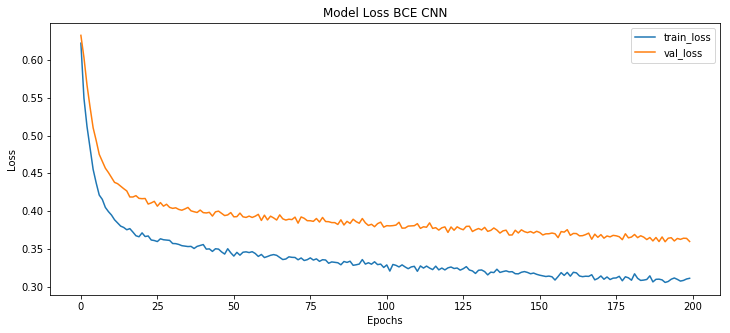

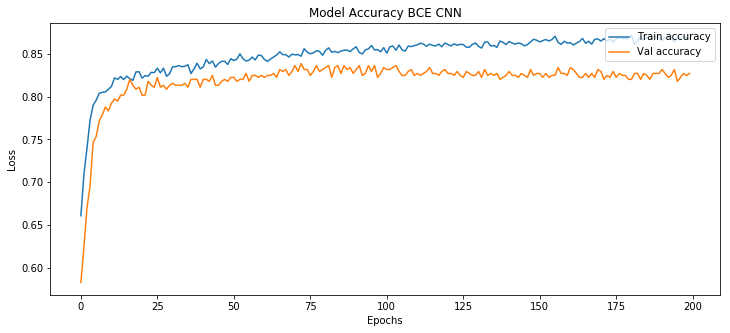

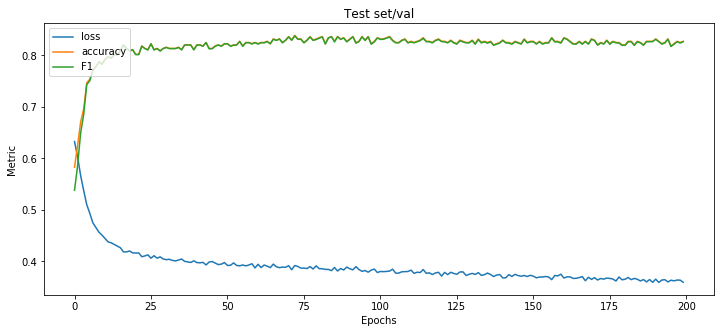

In [14]:
train_model(meta, x_train, y_train, x_val, y_val, e=200, BS=128, focal=False,alpha=0.6,save_f='./models/baseline_metadata.hdf5')

,F1 macro,F1 micro,F1 raw,F1 weighted,Precision raw,Recall raw
False Positive,0.871313,0.879041,0.902848,0.880783,0.944785,0.864475
Confirmed,0.871313,0.879041,0.839779,0.880783,0.782497,0.906110


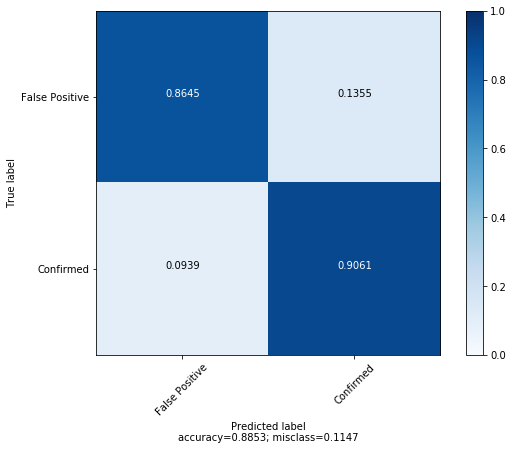

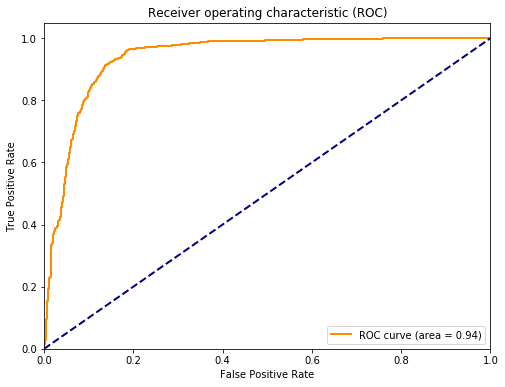

In [10]:
meta_loaded = keras.models.load_model("./models/baseline_metadata.hdf5") #con 4 capas (64 y 128) con dropa en todo
#meta_loaded.summary()

predichos=meta_loaded.predict_classes(x_val)
calculate_metrics(y_val, predichos,'[VAL] Confusion Matrix 200 epochs - METADATA') #con 3 capas aumentando/double

predichos_prob = meta_loaded.predict(x_val)
plot_ROC(y_val, predichos_prob)

#### Fourier

In [8]:
### ALL
folder_lc = "/work/work_teamEXOPLANET/KOI_LC/"
process_lc = np.load(folder_lc+'/cleaned/LC_kepler_processed.npy')
process_lc = process_lc/np.nanstd(process_lc, axis=1, keepdims=True) #escalar
process_lc = np.nan_to_num(process_lc) #borrar nans... arreglo variable

x_all = np.abs( np.fft.fft(process_lc, axis=1) ) #fourier
from sklearn.preprocessing import StandardScaler
x_all = StandardScaler().fit_transform(x_all)

x_train = x_all[mask_train]
x_val = x_all[mask_test]

if x_train.shape[0] < y_train.shape[0]:
    y_train = y_train[:x_train.shape[0]]
    
print ("Objetos de entrenamiento:",x_train.shape, y_train.shape)
print ("Objetos de validación:",x_val.shape,y_val.shape)

Objetos de entrenamiento: (4339, 71427) (4339,)
Objetos de validación: (1918, 71427) (1918,)






Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Train on 3905 samples, validate on 434 samples
Epoch 1/200
3905/3905 [==============================] - 6s 1ms/step - loss: 4.3727 - acc: 0.6238 - val_loss: 2.5530 - val_acc: 0.6221
Epoch 2/200
3905/3905 [==============================] - 4s 1ms/step - loss: 3.1416 - acc: 0.7370 - val_loss: 5.6296 - val_acc: 0.5276
Epoch 3/200
3905/3905 [==============================] - 4s 1ms/step - loss: 1.5348 - acc: 0.8036 - val_loss: 1.2048 - val_acc: 0.5760
Epoch 4/200
3905/3905 [==============================] - 4s 1ms/step - loss: 0.7894 - acc: 0.8592 - val_loss: 1.3453 - val_acc: 0.5622
Epoch 5/200
3905/3905 [==============================] - 6s 1ms/step - loss: 0.7088 - acc: 0.8988 - val_loss: 1.2891 - val_acc: 0.5714
Epoch 6/200
3905/3905 [==============================] - 6s 1ms

Epoch 27/200
3905/3905 [==============================] - 6s 1ms/step - loss: 0.5132 - acc: 0.9644 - val_loss: 2.3981 - val_acc: 0.5714
Epoch 28/200
3905/3905 [==============================] - 5s 1ms/step - loss: 0.5239 - acc: 0.9649 - val_loss: 2.1566 - val_acc: 0.5760
Epoch 29/200
3905/3905 [==============================] - 5s 1ms/step - loss: 0.5193 - acc: 0.9626 - val_loss: 2.1800 - val_acc: 0.5853
Epoch 30/200
3905/3905 [==============================] - 5s 1ms/step - loss: 0.5142 - acc: 0.9654 - val_loss: 2.2128 - val_acc: 0.5806
Epoch 31/200
3905/3905 [==============================] - 5s 1ms/step - loss: 0.5076 - acc: 0.9667 - val_loss: 2.2565 - val_acc: 0.5899
Epoch 32/200
3905/3905 [==============================] - 5s 1ms/step - loss: 0.5164 - acc: 0.9644 - val_loss: 1.8842 - val_acc: 0.5991
Epoch 33/200
3905/3905 [==============================] - 5s 1ms/step - loss: 0.5139 - acc: 0.9644 - val_loss: 2.3701 - val_acc: 0.5783
Epoch 34/200
3905/3905 [========================

Epoch 62/200
3905/3905 [==============================] - 5s 1ms/step - loss: 0.5085 - acc: 0.9667 - val_loss: 2.4729 - val_acc: 0.5737
Epoch 63/200
3905/3905 [==============================] - 5s 1ms/step - loss: 0.5003 - acc: 0.9654 - val_loss: 2.2893 - val_acc: 0.5829
Epoch 64/200
3905/3905 [==============================] - 6s 1ms/step - loss: 0.5125 - acc: 0.9659 - val_loss: 2.5108 - val_acc: 0.6060
Epoch 65/200
3905/3905 [==============================] - 5s 1ms/step - loss: 0.5015 - acc: 0.9667 - val_loss: 2.5074 - val_acc: 0.6083
Epoch 66/200
3905/3905 [==============================] - 5s 1ms/step - loss: 0.5027 - acc: 0.9652 - val_loss: 2.3158 - val_acc: 0.5922
Epoch 67/200
3905/3905 [==============================] - 5s 1ms/step - loss: 0.5020 - acc: 0.9667 - val_loss: 2.5325 - val_acc: 0.5829
Epoch 68/200
3905/3905 [==============================] - 5s 1ms/step - loss: 0.5003 - acc: 0.9677 - val_loss: 2.1868 - val_acc: 0.6014
Epoch 69/200
3905/3905 [========================

Epoch 97/200
3905/3905 [==============================] - 5s 1ms/step - loss: 0.4977 - acc: 0.9657 - val_loss: 2.7719 - val_acc: 0.5853
Epoch 98/200
3905/3905 [==============================] - 5s 1ms/step - loss: 0.4995 - acc: 0.9670 - val_loss: 2.9046 - val_acc: 0.5945
Epoch 99/200
3905/3905 [==============================] - 5s 1ms/step - loss: 0.4933 - acc: 0.9672 - val_loss: 3.0755 - val_acc: 0.5876
Epoch 100/200
3905/3905 [==============================] - 6s 1ms/step - loss: 0.5028 - acc: 0.9649 - val_loss: 2.8369 - val_acc: 0.5968
Epoch 101/200
3905/3905 [==============================] - 6s 1ms/step - loss: 0.5021 - acc: 0.9657 - val_loss: 2.5229 - val_acc: 0.6014
Epoch 102/200
3905/3905 [==============================] - 5s 1ms/step - loss: 0.4901 - acc: 0.9659 - val_loss: 2.6970 - val_acc: 0.5760
Epoch 103/200
3905/3905 [==============================] - 5s 1ms/step - loss: 0.5024 - acc: 0.9667 - val_loss: 3.1306 - val_acc: 0.5714
Epoch 104/200
3905/3905 [===================

3905/3905 [==============================] - 6s 1ms/step - loss: 0.4819 - acc: 0.9667 - val_loss: 4.0397 - val_acc: 0.5806
Epoch 166/200
3905/3905 [==============================] - 6s 1ms/step - loss: 0.5153 - acc: 0.9634 - val_loss: 3.5126 - val_acc: 0.5876
Epoch 167/200
3905/3905 [==============================] - 6s 1ms/step - loss: 0.4935 - acc: 0.9672 - val_loss: 4.3863 - val_acc: 0.5876
Epoch 168/200
3905/3905 [==============================] - 5s 1ms/step - loss: 0.4945 - acc: 0.9659 - val_loss: 4.2090 - val_acc: 0.5922
Epoch 169/200
3905/3905 [==============================] - 5s 1ms/step - loss: 0.4801 - acc: 0.9672 - val_loss: 4.4052 - val_acc: 0.5737
Epoch 170/200
3905/3905 [==============================] - 5s 1ms/step - loss: 0.5464 - acc: 0.9595 - val_loss: 3.9035 - val_acc: 0.6244
Epoch 171/200
3905/3905 [==============================] - 5s 1ms/step - loss: 0.5162 - acc: 0.9639 - val_loss: 3.8596 - val_acc: 0.5806
Epoch 172/200
3905/3905 [==============================

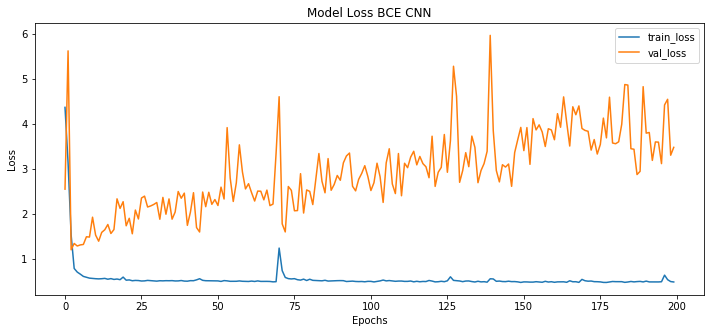

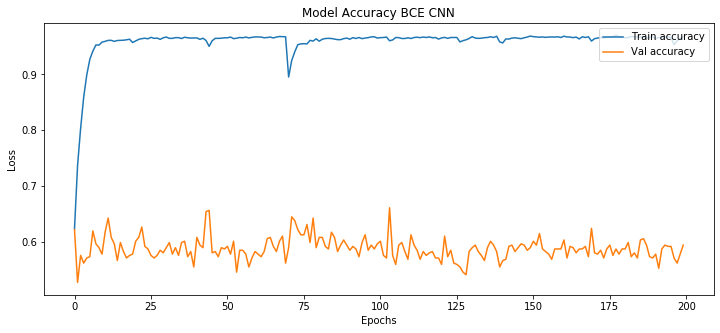

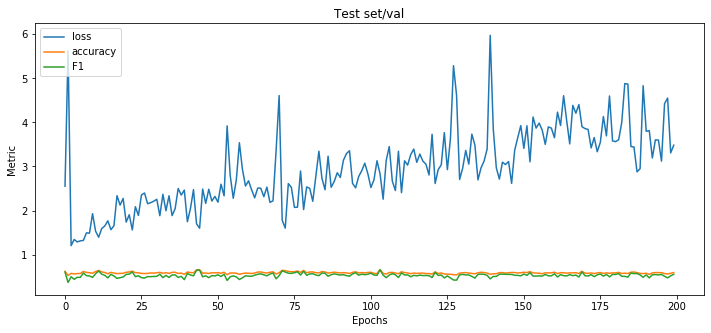

In [9]:
all_lc = Sequential()
all_lc.add(Dense(128, input_shape=x_train.shape[1:], activation='relu'))
all_lc.add(Dropout(0.5))
all_lc.add(Dense(1, activation='sigmoid'))

train_model(all_lc, x_train, y_train, x_val, y_val, e=200, BS=128, focal=False,alpha=0.6,save_f='./models/aux.hdf5')

,Precision raw,Recall raw,F1 raw,F1 weighted,F1 macro,F1 micro
False Positive,0.729045,0.899759,0.805456,0.69293,0.644633,0.717414
Confirmed,0.670185,0.378539,0.483810,0.69293,0.644633,0.717414


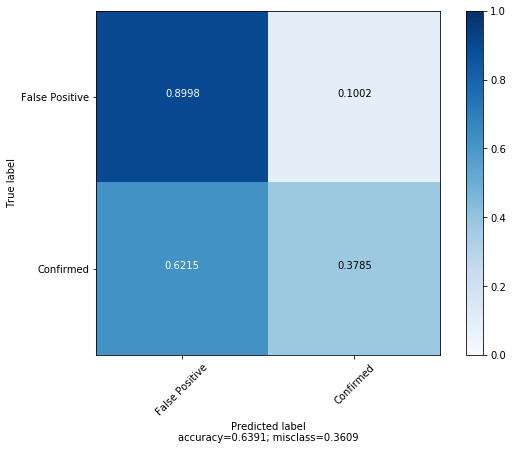

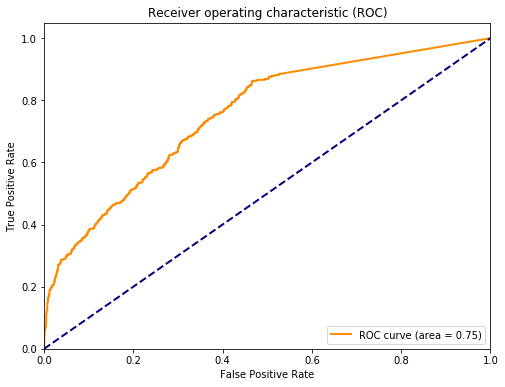

In [10]:
all_lc = keras.models.load_model("./models/aux.hdf5") #con 4 capas (64 y 128) con dropa en todo
#ff_loaded.summary()

predichos=all_lc.predict_classes(x_val)
calculate_metrics(y_val, predichos,'[VAL] Confusion Matrix 200 epochs - FOURIER UNFOLDED') #con 3 capas aumentando/double

predichos_prob = all_lc.predict(x_val)
plot_ROC(y_val, predichos_prob)

#### Fourier + PCA

#### 32

Objetos de entrenamiento: (4339, 32) (4339,)
Objetos de validación: (1918, 32) (1918,)
Train on 3905 samples, validate on 434 samples
Epoch 1/200
3905/3905 [==============================] - 2s 394us/step - loss: 2.4623 - acc: 0.6269 - val_loss: 1.3438 - val_acc: 0.6083
Epoch 2/200
3905/3905 [==============================] - 0s 45us/step - loss: 2.0023 - acc: 0.6407 - val_loss: 1.2369 - val_acc: 0.6382
Epoch 3/200
3905/3905 [==============================] - 0s 52us/step - loss: 1.6156 - acc: 0.6515 - val_loss: 1.2356 - val_acc: 0.6198
Epoch 4/200
3905/3905 [==============================] - 0s 53us/step - loss: 1.3505 - acc: 0.6433 - val_loss: 1.1970 - val_acc: 0.6406
Epoch 5/200
3905/3905 [==============================] - 0s 46us/step - loss: 1.1376 - acc: 0.6466 - val_loss: 1.2502 - val_acc: 0.6152
Epoch 6/200
3905/3905 [==============================] - 0s 45us/step - loss: 1.0460 - acc: 0.6433 - val_loss: 1.2274 - val_acc: 0.6244
Epoch 7/200
3905/3905 [==========================

Epoch 35/200
3905/3905 [==============================] - 0s 42us/step - loss: 0.5477 - acc: 0.6909 - val_loss: 0.7238 - val_acc: 0.6521
Epoch 36/200
3905/3905 [==============================] - 0s 50us/step - loss: 0.5396 - acc: 0.7096 - val_loss: 0.7016 - val_acc: 0.6359
Epoch 37/200
3905/3905 [==============================] - 0s 44us/step - loss: 0.5390 - acc: 0.7001 - val_loss: 0.7387 - val_acc: 0.6267
Epoch 38/200
3905/3905 [==============================] - 0s 50us/step - loss: 0.5319 - acc: 0.6983 - val_loss: 0.6942 - val_acc: 0.6498
Epoch 39/200
3905/3905 [==============================] - 0s 44us/step - loss: 0.5341 - acc: 0.6963 - val_loss: 0.7457 - val_acc: 0.5853
Epoch 40/200
3905/3905 [==============================] - 0s 51us/step - loss: 0.5295 - acc: 0.7140 - val_loss: 0.6711 - val_acc: 0.6267
Epoch 41/200
3905/3905 [==============================] - 0s 50us/step - loss: 0.5251 - acc: 0.7073 - val_loss: 0.6488 - val_acc: 0.6336
Epoch 42/200
3905/3905 [=================

3905/3905 [==============================] - 0s 42us/step - loss: 0.5032 - acc: 0.7239 - val_loss: 0.6205 - val_acc: 0.6406
Epoch 104/200
3905/3905 [==============================] - 0s 42us/step - loss: 0.4975 - acc: 0.7283 - val_loss: 0.6306 - val_acc: 0.6636
Epoch 105/200
3905/3905 [==============================] - 0s 43us/step - loss: 0.4952 - acc: 0.7316 - val_loss: 0.6337 - val_acc: 0.6382
Epoch 106/200
3905/3905 [==============================] - 0s 43us/step - loss: 0.4976 - acc: 0.7237 - val_loss: 0.6356 - val_acc: 0.6175
Epoch 107/200
3905/3905 [==============================] - 0s 43us/step - loss: 0.4932 - acc: 0.7321 - val_loss: 0.6126 - val_acc: 0.6244
Epoch 108/200
3905/3905 [==============================] - 0s 43us/step - loss: 0.4973 - acc: 0.7242 - val_loss: 0.6168 - val_acc: 0.6590
Epoch 109/200
3905/3905 [==============================] - 0s 43us/step - loss: 0.4946 - acc: 0.7296 - val_loss: 0.6153 - val_acc: 0.6498
Epoch 110/200
3905/3905 [=======================

3905/3905 [==============================] - 0s 43us/step - loss: 0.4749 - acc: 0.7426 - val_loss: 0.6499 - val_acc: 0.6613
Epoch 172/200
3905/3905 [==============================] - 0s 42us/step - loss: 0.4724 - acc: 0.7434 - val_loss: 0.6597 - val_acc: 0.6498
Epoch 173/200
3905/3905 [==============================] - 0s 44us/step - loss: 0.4755 - acc: 0.7401 - val_loss: 0.6564 - val_acc: 0.6382
Epoch 174/200
3905/3905 [==============================] - 0s 43us/step - loss: 0.4658 - acc: 0.7493 - val_loss: 0.6486 - val_acc: 0.6498
Epoch 175/200
3905/3905 [==============================] - 0s 44us/step - loss: 0.4681 - acc: 0.7506 - val_loss: 0.6752 - val_acc: 0.6359
Epoch 176/200
3905/3905 [==============================] - 0s 43us/step - loss: 0.4694 - acc: 0.7472 - val_loss: 0.6619 - val_acc: 0.6567
Epoch 177/200
3905/3905 [==============================] - 0s 43us/step - loss: 0.4791 - acc: 0.7408 - val_loss: 0.6415 - val_acc: 0.6774
Epoch 178/200
3905/3905 [=======================

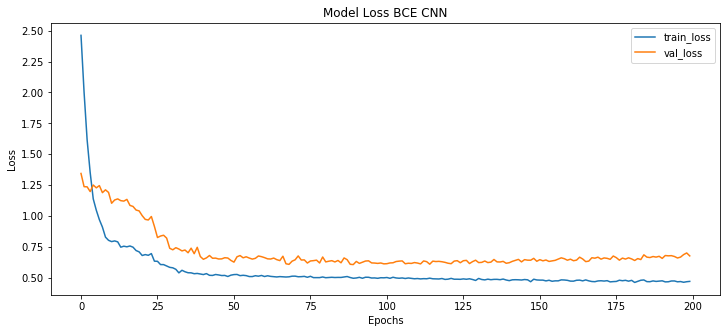

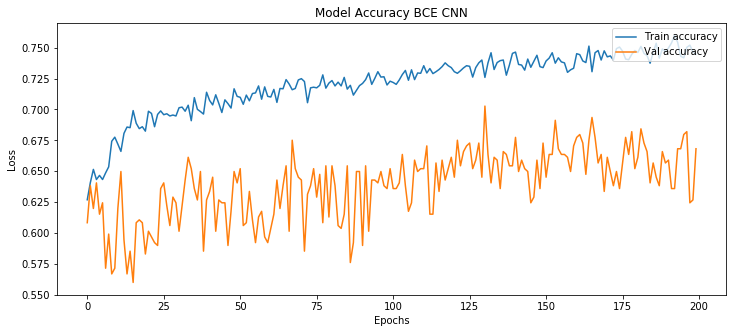

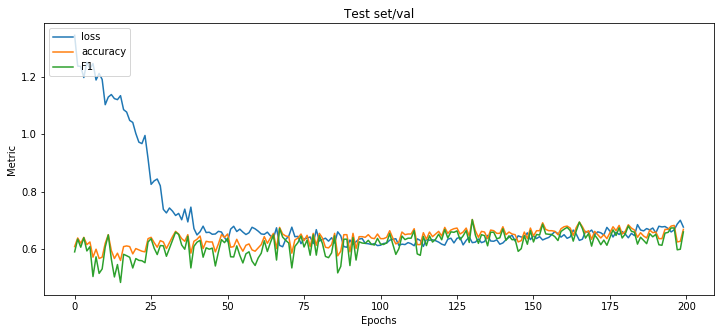

In [30]:
x_all=np.load("../obj4/LC_features/FourierPCA_71427T_32D.npy")
x_train = x_all[mask_train]
x_val = x_all[mask_test]

if x_train.shape[0] < y_train.shape[0]:
    y_train = y_train[:x_train.shape[0]]
    
print ("Objetos de entrenamiento:",x_train.shape, y_train.shape)
print ("Objetos de validación:",x_val.shape,y_val.shape)

f = Sequential()
f.add(Dense(128, input_shape=x_train.shape[1:], activation='relu'))
f.add(Dropout(0.5))
f.add(Dense(1, activation='sigmoid'))

train_model(f, x_train, y_train, x_val, y_val, e=200, BS=128, focal=False,alpha=0.6,save_f='./models/baseline_funfolded.hdf5')

,Precision raw,Recall raw,F1 raw,F1 weighted,F1 macro,F1 micro
False Positive,0.771982,0.830794,0.800309,0.725126,0.692857,0.730448
Confirmed,0.633681,0.543964,0.585405,0.725126,0.692857,0.730448


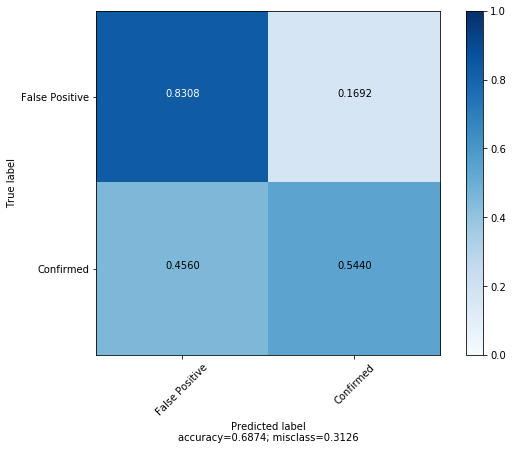

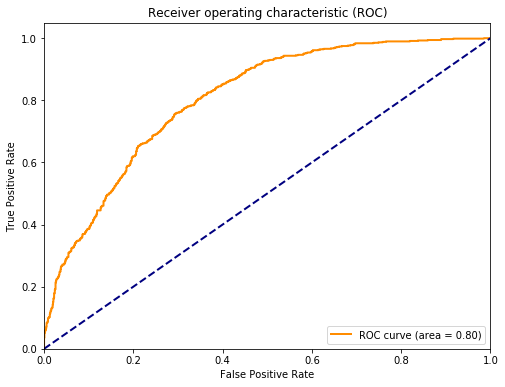

In [15]:
f_loaded = keras.models.load_model("./models/baseline_funfolded.hdf5") #con 4 capas (64 y 128) con dropa en todo
#ff_loaded.summary()

predichos=f_loaded.predict_classes(x_val)
calculate_metrics(y_val, predichos,'[VAL] Confusion Matrix 200 epochs - FOURIER UNFOLDED') #con 3 capas aumentando/double

predichos_prob = f_loaded.predict(x_val)
plot_ROC(y_val, predichos_prob)

#### 30x30x2

Objetos de entrenamiento: (4339, 1800) (4339,)
Objetos de validación: (1918, 1800) (1918,)
Train on 3905 samples, validate on 434 samples
Epoch 1/200
3905/3905 [==============================] - 1s 287us/step - loss: 2.0407 - acc: 0.6115 - val_loss: 1.4918 - val_acc: 0.6267
Epoch 2/200
3905/3905 [==============================] - 0s 65us/step - loss: 0.9072 - acc: 0.7844 - val_loss: 1.4419 - val_acc: 0.6290
Epoch 3/200
3905/3905 [==============================] - 0s 66us/step - loss: 0.6074 - acc: 0.8407 - val_loss: 1.4163 - val_acc: 0.6590
Epoch 4/200
3905/3905 [==============================] - 0s 60us/step - loss: 0.4144 - acc: 0.8822 - val_loss: 1.4604 - val_acc: 0.6498
Epoch 5/200
3905/3905 [==============================] - 0s 62us/step - loss: 0.3129 - acc: 0.9160 - val_loss: 1.4953 - val_acc: 0.6452
Epoch 6/200
3905/3905 [==============================] - 0s 59us/step - loss: 0.2516 - acc: 0.9309 - val_loss: 1.5501 - val_acc: 0.6406
Epoch 7/200
3905/3905 [======================

Epoch 35/200
3905/3905 [==============================] - 0s 62us/step - loss: 0.0555 - acc: 0.9923 - val_loss: 2.0833 - val_acc: 0.6221
Epoch 36/200
3905/3905 [==============================] - 0s 59us/step - loss: 0.0525 - acc: 0.9921 - val_loss: 2.0921 - val_acc: 0.6221
Epoch 37/200
3905/3905 [==============================] - 0s 60us/step - loss: 0.0509 - acc: 0.9939 - val_loss: 2.1257 - val_acc: 0.6152
Epoch 38/200
3905/3905 [==============================] - 0s 60us/step - loss: 0.0535 - acc: 0.9931 - val_loss: 2.1269 - val_acc: 0.6106
Epoch 39/200
3905/3905 [==============================] - 0s 63us/step - loss: 0.0540 - acc: 0.9923 - val_loss: 2.1904 - val_acc: 0.6060
Epoch 40/200
3905/3905 [==============================] - 0s 60us/step - loss: 0.0544 - acc: 0.9910 - val_loss: 2.1918 - val_acc: 0.6175
Epoch 41/200
3905/3905 [==============================] - 0s 58us/step - loss: 0.0607 - acc: 0.9921 - val_loss: 2.1807 - val_acc: 0.6152
Epoch 42/200
3905/3905 [=================

3905/3905 [==============================] - 0s 63us/step - loss: 0.0458 - acc: 0.9923 - val_loss: 2.9578 - val_acc: 0.6152
Epoch 104/200
3905/3905 [==============================] - 0s 65us/step - loss: 0.0498 - acc: 0.9923 - val_loss: 3.0031 - val_acc: 0.5991
Epoch 105/200
3905/3905 [==============================] - 0s 62us/step - loss: 0.0429 - acc: 0.9944 - val_loss: 3.0003 - val_acc: 0.5945
Epoch 106/200
3905/3905 [==============================] - 0s 66us/step - loss: 0.0449 - acc: 0.9931 - val_loss: 2.9902 - val_acc: 0.5991
Epoch 107/200
3905/3905 [==============================] - 0s 63us/step - loss: 0.0388 - acc: 0.9939 - val_loss: 3.0319 - val_acc: 0.5991
Epoch 108/200
3905/3905 [==============================] - 0s 62us/step - loss: 0.0398 - acc: 0.9933 - val_loss: 3.0313 - val_acc: 0.6060
Epoch 109/200
3905/3905 [==============================] - 0s 63us/step - loss: 0.0375 - acc: 0.9939 - val_loss: 3.1652 - val_acc: 0.5968
Epoch 110/200
3905/3905 [=======================

3905/3905 [==============================] - 0s 62us/step - loss: 0.0543 - acc: 0.9933 - val_loss: 3.3353 - val_acc: 0.6175
Epoch 172/200
3905/3905 [==============================] - 0s 60us/step - loss: 0.0450 - acc: 0.9918 - val_loss: 3.4138 - val_acc: 0.6198
Epoch 173/200
3905/3905 [==============================] - 0s 61us/step - loss: 0.0551 - acc: 0.9918 - val_loss: 3.4591 - val_acc: 0.6175
Epoch 174/200
3905/3905 [==============================] - 0s 60us/step - loss: 0.0416 - acc: 0.9933 - val_loss: 3.4744 - val_acc: 0.6129
Epoch 175/200
3905/3905 [==============================] - 0s 59us/step - loss: 0.0507 - acc: 0.9926 - val_loss: 3.4371 - val_acc: 0.6175
Epoch 176/200
3905/3905 [==============================] - 0s 60us/step - loss: 0.0445 - acc: 0.9923 - val_loss: 3.6944 - val_acc: 0.5899
Epoch 177/200
3905/3905 [==============================] - 0s 66us/step - loss: 0.0434 - acc: 0.9923 - val_loss: 3.6906 - val_acc: 0.5853
Epoch 178/200
3905/3905 [=======================

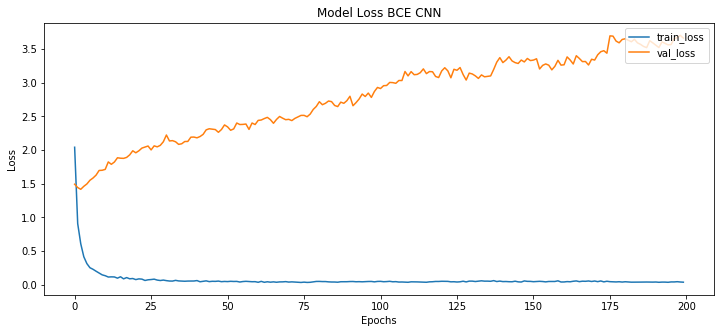

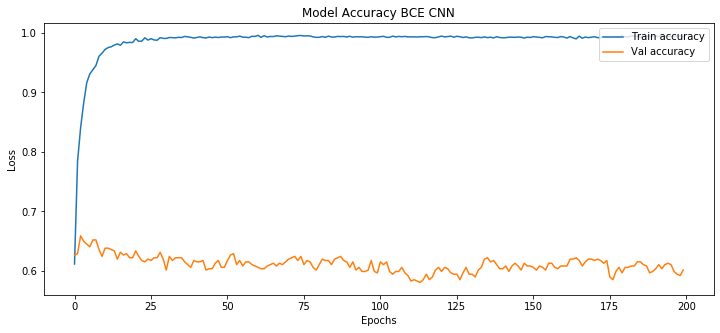

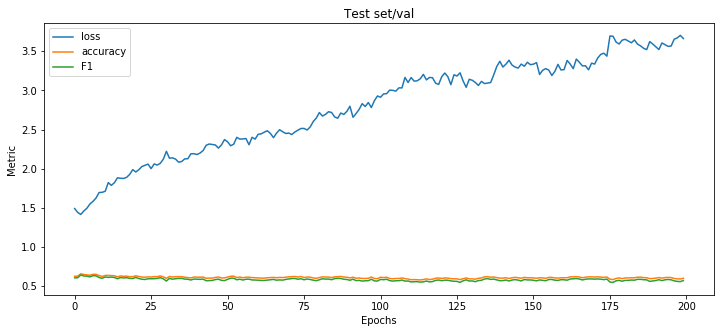

In [10]:
x_all=np.load("../obj4/LC_features/FourierPCA_71427T_1800D.npy")
x_train = x_all[mask_train]
x_val = x_all[mask_test]

if x_train.shape[0] < y_train.shape[0]:
    y_train = y_train[:x_train.shape[0]]
    
print ("Objetos de entrenamiento:",x_train.shape, y_train.shape)
print ("Objetos de validación:",x_val.shape,y_val.shape)

f2 = Sequential()
f2.add(Dense(128, input_shape=x_train.shape[1:], activation='relu'))
f2.add(Dropout(0.5))
f2.add(Dense(1, activation='sigmoid'))

train_model(f2, x_train, y_train, x_val, y_val, e=200, BS=128, focal=False,alpha=0.6,save_f='./models/baseline_funfolded2.hdf5')

,Precision raw,Recall raw,F1 raw,F1 weighted,F1 macro,F1 micro
False Positive,0.776646,0.794707,0.785573,0.716441,0.68677,0.717935
Confirmed,0.601246,0.575261,0.587966,0.716441,0.68677,0.717935


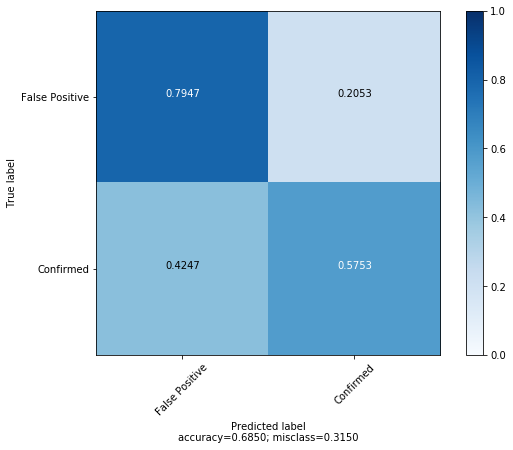

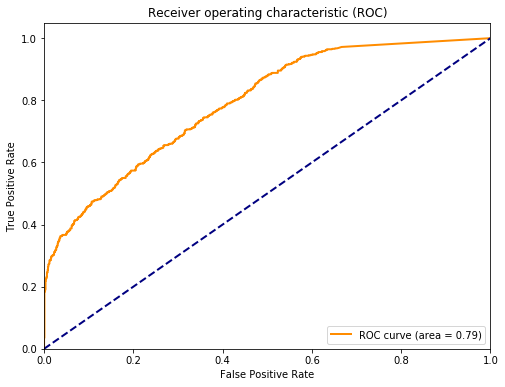

In [17]:
f2_loaded = keras.models.load_model("./models/baseline_funfolded2.hdf5") #con 4 capas (64 y 128) con dropa en todo
#f2_loaded.summary()

predichos=f2_loaded.predict_classes(x_val)
calculate_metrics(y_val, predichos,'[VAL] Confusion Matrix 200 epochs - FOURIER UNFOLDED') #con 3 capas aumentando/double

predichos_prob = f2_loaded.predict(x_val)
plot_ROC(y_val, predichos_prob)

## Fold experiments
#### All measurements (T=300)

Objetos de entrenamiento: (4339, 300) (4339,)
Objetos de validación: (1918, 300) (1918,)
Train on 3905 samples, validate on 434 samples
Epoch 1/200
3905/3905 [==============================] - 1s 229us/step - loss: 0.6774 - acc: 0.6510 - val_loss: 0.5552 - val_acc: 0.7488
 - val_f1: 0.746803 
Epoch 2/200
3905/3905 [==============================] - 0s 58us/step - loss: 0.5211 - acc: 0.7439 - val_loss: 0.5257 - val_acc: 0.7465
 - val_f1: 0.744586 
Epoch 3/200
3905/3905 [==============================] - 0s 73us/step - loss: 0.4645 - acc: 0.7721 - val_loss: 0.5246 - val_acc: 0.7627
 - val_f1: 0.758204 
Epoch 4/200
3905/3905 [==============================] - 0s 55us/step - loss: 0.4333 - acc: 0.7992 - val_loss: 0.5162 - val_acc: 0.7581
 - val_f1: 0.754677 
Epoch 5/200
3905/3905 [==============================] - 0s 54us/step - loss: 0.4026 - acc: 0.8241 - val_loss: 0.5087 - val_acc: 0.7535
 - val_f1: 0.750530 
Epoch 6/200
3905/3905 [==============================] - 0s 54us/step - loss: 

3905/3905 [==============================] - 0s 52us/step - loss: 0.0991 - acc: 0.9680 - val_loss: 0.7509 - val_acc: 0.7535
 - val_f1: 0.749724 
Epoch 53/200
3905/3905 [==============================] - 0s 50us/step - loss: 0.0934 - acc: 0.9682 - val_loss: 0.7409 - val_acc: 0.7535
 - val_f1: 0.750530 
Epoch 54/200
3905/3905 [==============================] - 0s 48us/step - loss: 0.0991 - acc: 0.9688 - val_loss: 0.7514 - val_acc: 0.7627
 - val_f1: 0.758799 
Epoch 55/200
3905/3905 [==============================] - 0s 50us/step - loss: 0.0946 - acc: 0.9667 - val_loss: 0.7501 - val_acc: 0.7581
 - val_f1: 0.754402 
Epoch 56/200
3905/3905 [==============================] - 0s 50us/step - loss: 0.0922 - acc: 0.9680 - val_loss: 0.7436 - val_acc: 0.7604
 - val_f1: 0.756311 
Epoch 57/200
3905/3905 [==============================] - 0s 53us/step - loss: 0.0912 - acc: 0.9688 - val_loss: 0.7690 - val_acc: 0.7558
 - val_f1: 0.750672 
Epoch 58/200
3905/3905 [==============================] - 0s 50us

3905/3905 [==============================] - 0s 48us/step - loss: 0.0603 - acc: 0.9803 - val_loss: 1.0621 - val_acc: 0.7604
 - val_f1: 0.756011 
Epoch 105/200
3905/3905 [==============================] - 0s 52us/step - loss: 0.0652 - acc: 0.9798 - val_loss: 1.0627 - val_acc: 0.7627
 - val_f1: 0.758507 
Epoch 106/200
3905/3905 [==============================] - 0s 50us/step - loss: 0.0621 - acc: 0.9777 - val_loss: 1.0671 - val_acc: 0.7673
 - val_f1: 0.762899 
Epoch 107/200
3905/3905 [==============================] - 0s 49us/step - loss: 0.0581 - acc: 0.9808 - val_loss: 1.0293 - val_acc: 0.7558
 - val_f1: 0.751920 
Epoch 108/200
3905/3905 [==============================] - 0s 49us/step - loss: 0.0575 - acc: 0.9821 - val_loss: 1.0753 - val_acc: 0.7627
 - val_f1: 0.758507 
Epoch 109/200
3905/3905 [==============================] - 0s 46us/step - loss: 0.0653 - acc: 0.9777 - val_loss: 1.0767 - val_acc: 0.7650
 - val_f1: 0.760998 
Epoch 110/200
3905/3905 [==============================] - 0

 - val_f1: 0.748488 
Epoch 156/200
3905/3905 [==============================] - 0s 49us/step - loss: 0.0539 - acc: 0.9816 - val_loss: 1.3886 - val_acc: 0.7512
 - val_f1: 0.745968 
Epoch 157/200
3905/3905 [==============================] - 0s 48us/step - loss: 0.0498 - acc: 0.9816 - val_loss: 1.4310 - val_acc: 0.7396
 - val_f1: 0.732471 
Epoch 158/200
3905/3905 [==============================] - 0s 48us/step - loss: 0.0435 - acc: 0.9857 - val_loss: 1.3905 - val_acc: 0.7512
 - val_f1: 0.745261 
Epoch 159/200
3905/3905 [==============================] - 0s 49us/step - loss: 0.0469 - acc: 0.9844 - val_loss: 1.4302 - val_acc: 0.7465
 - val_f1: 0.739774 
Epoch 160/200
3905/3905 [==============================] - 0s 49us/step - loss: 0.0468 - acc: 0.9844 - val_loss: 1.4536 - val_acc: 0.7488
 - val_f1: 0.742335 
Epoch 161/200
3905/3905 [==============================] - 0s 51us/step - loss: 0.0468 - acc: 0.9839 - val_loss: 1.4309 - val_acc: 0.7604
 - val_f1: 0.755376 
Epoch 162/200
3905/3905 [

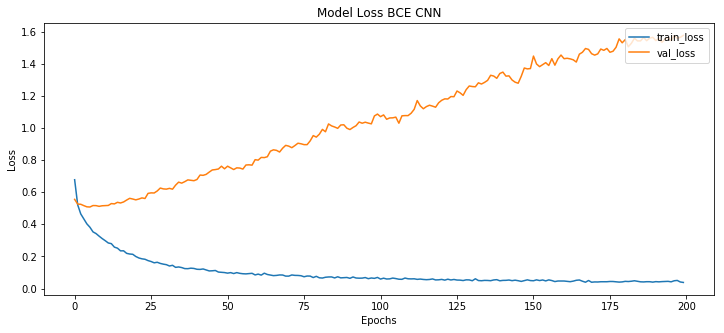

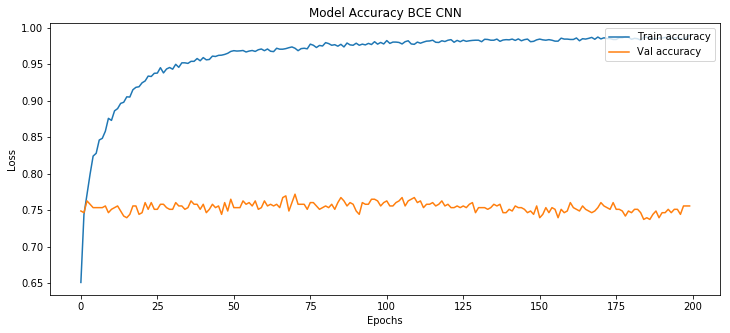

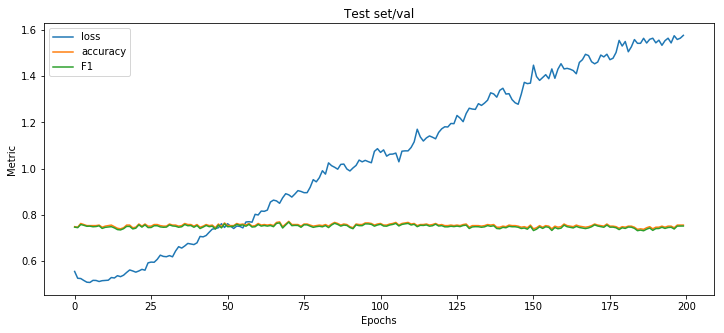

In [12]:
T = 300
x_all = np.load("../obj4/data/LC_global_%dT.npy"%T)
x_all = x_all/x_all.std(axis=1, keepdims=True)

#add time x_all2 = np.load("../obj4/data/Time_global_%dT.npy"%T)
#x_all = np.concatenate([x_all,x_all2], axis=-1)


x_train = x_all[mask_train]
x_val = x_all[mask_test]

if x_train.shape[0] < y_train.shape[0]:
    y_train = y_train[:x_train.shape[0]]
    
print ("Objetos de entrenamiento:",x_train.shape, y_train.shape)
print ("Objetos de validación:",x_val.shape,y_val.shape)

foldT = Sequential()
foldT.add(Dense(128, input_shape=x_train.shape[1:], activation='relu'))
foldT.add(Dropout(0.5))
foldT.add(Dense(1, activation='sigmoid'))

train_model(foldT, x_train, y_train, x_val, y_val, e=200, BS=128, focal=False,alpha=0.6,save_f='./models/baseline_foldT.hdf5')

,F1 macro,F1 micro,F1 raw,F1 weighted,Precision raw,Recall raw
False Positive,0.764554,0.785714,0.835138,0.785751,0.835474,0.834804
Confirmed,0.764554,0.785714,0.693969,0.785751,0.693452,0.694486


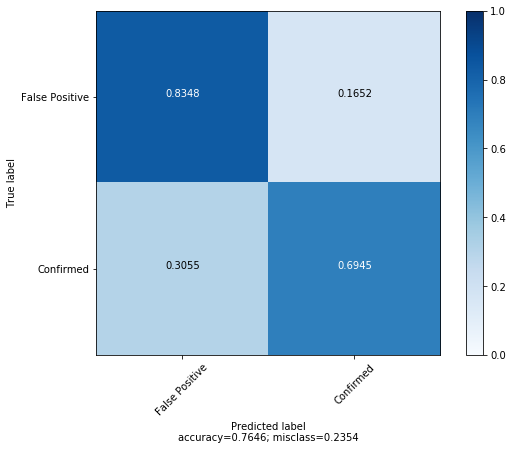

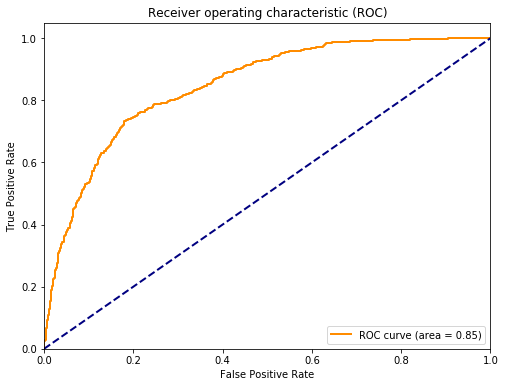

In [13]:
foldT_loaded = keras.models.load_model("./models/baseline_foldT.hdf5") #con 4 capas (64 y 128) con dropa en todo
#ff_loaded.summary()

predichos=foldT_loaded.predict_classes(x_val)
calculate_metrics(y_val, predichos,'[VAL] Confusion Matrix 200 epochs - VAE') #con 3 capas aumentando/double

predichos_prob = foldT_loaded.predict(x_val)
plot_ROC(y_val, predichos_prob)

#### AE

Objetos de entrenamiento: (4339, 16) (4339,)
Objetos de validación: (1918, 16) (1918,)
Train on 3905 samples, validate on 434 samples
Epoch 1/200
3905/3905 [==============================] - 1s 185us/step - loss: 0.6603 - acc: 0.6092 - val_loss: 0.6991 - val_acc: 0.5184
 - val_f1: 0.341426 
Epoch 2/200
3905/3905 [==============================] - 0s 53us/step - loss: 0.6208 - acc: 0.6394 - val_loss: 0.6734 - val_acc: 0.5184
 - val_f1: 0.353923 
Epoch 3/200
3905/3905 [==============================] - 0s 50us/step - loss: 0.5957 - acc: 0.6469 - val_loss: 0.6474 - val_acc: 0.5276
 - val_f1: 0.417106 
Epoch 4/200
3905/3905 [==============================] - 0s 50us/step - loss: 0.5773 - acc: 0.6517 - val_loss: 0.6292 - val_acc: 0.5922
 - val_f1: 0.553972 
Epoch 5/200
3905/3905 [==============================] - 0s 56us/step - loss: 0.5659 - acc: 0.6727 - val_loss: 0.6215 - val_acc: 0.6129
 - val_f1: 0.589321 
Epoch 6/200
3905/3905 [==============================] - 0s 45us/step - loss: 0.

3905/3905 [==============================] - 0s 49us/step - loss: 0.4976 - acc: 0.7462 - val_loss: 0.5788 - val_acc: 0.6959
 - val_f1: 0.691423 
Epoch 53/200
3905/3905 [==============================] - 0s 48us/step - loss: 0.4992 - acc: 0.7488 - val_loss: 0.5670 - val_acc: 0.7120
 - val_f1: 0.709873 
Epoch 54/200
3905/3905 [==============================] - 0s 47us/step - loss: 0.4981 - acc: 0.7421 - val_loss: 0.5731 - val_acc: 0.7051
 - val_f1: 0.701718 
Epoch 55/200
3905/3905 [==============================] - 0s 49us/step - loss: 0.4955 - acc: 0.7493 - val_loss: 0.5798 - val_acc: 0.7005
 - val_f1: 0.695389 
Epoch 56/200
3905/3905 [==============================] - 0s 48us/step - loss: 0.4950 - acc: 0.7513 - val_loss: 0.5749 - val_acc: 0.6959
 - val_f1: 0.692086 
Epoch 57/200
3905/3905 [==============================] - 0s 44us/step - loss: 0.4974 - acc: 0.7485 - val_loss: 0.5804 - val_acc: 0.6959
 - val_f1: 0.689926 
Epoch 58/200
3905/3905 [==============================] - 0s 49us

3905/3905 [==============================] - 0s 49us/step - loss: 0.4872 - acc: 0.7503 - val_loss: 0.5740 - val_acc: 0.6935
 - val_f1: 0.686517 
Epoch 105/200
3905/3905 [==============================] - 0s 50us/step - loss: 0.4823 - acc: 0.7521 - val_loss: 0.5556 - val_acc: 0.7097
 - val_f1: 0.707666 
Epoch 106/200
3905/3905 [==============================] - 0s 50us/step - loss: 0.4857 - acc: 0.7519 - val_loss: 0.5585 - val_acc: 0.7051
 - val_f1: 0.702281 
Epoch 107/200
3905/3905 [==============================] - 0s 48us/step - loss: 0.4840 - acc: 0.7542 - val_loss: 0.5592 - val_acc: 0.7005
 - val_f1: 0.697350 
Epoch 108/200
3905/3905 [==============================] - 0s 50us/step - loss: 0.4840 - acc: 0.7552 - val_loss: 0.5632 - val_acc: 0.7051
 - val_f1: 0.702281 
Epoch 109/200
3905/3905 [==============================] - 0s 48us/step - loss: 0.4814 - acc: 0.7539 - val_loss: 0.5688 - val_acc: 0.6935
 - val_f1: 0.688170 
Epoch 110/200
3905/3905 [==============================] - 0

 - val_f1: 0.682671 
Epoch 156/200
3905/3905 [==============================] - 0s 48us/step - loss: 0.4731 - acc: 0.7593 - val_loss: 0.5540 - val_acc: 0.7051
 - val_f1: 0.702542 
Epoch 157/200
3905/3905 [==============================] - 0s 48us/step - loss: 0.4770 - acc: 0.7519 - val_loss: 0.5626 - val_acc: 0.7005
 - val_f1: 0.695751 
Epoch 158/200
3905/3905 [==============================] - 0s 49us/step - loss: 0.4766 - acc: 0.7588 - val_loss: 0.5514 - val_acc: 0.7051
 - val_f1: 0.703248 
Epoch 159/200
3905/3905 [==============================] - 0s 47us/step - loss: 0.4760 - acc: 0.7570 - val_loss: 0.5470 - val_acc: 0.7051
 - val_f1: 0.703248 
Epoch 160/200
3905/3905 [==============================] - 0s 48us/step - loss: 0.4767 - acc: 0.7560 - val_loss: 0.5524 - val_acc: 0.7074
 - val_f1: 0.704991 
Epoch 161/200
3905/3905 [==============================] - 0s 47us/step - loss: 0.4789 - acc: 0.7560 - val_loss: 0.5682 - val_acc: 0.6866
 - val_f1: 0.680108 
Epoch 162/200
3905/3905 [

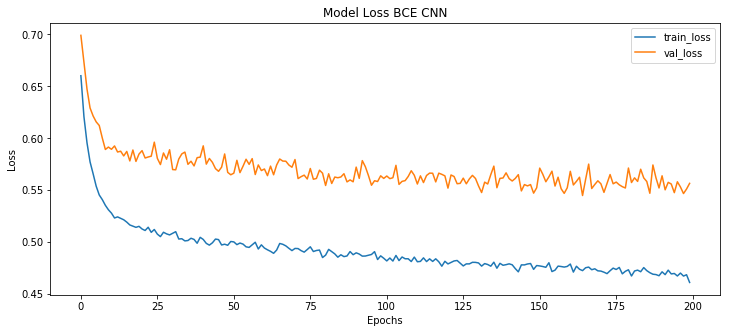

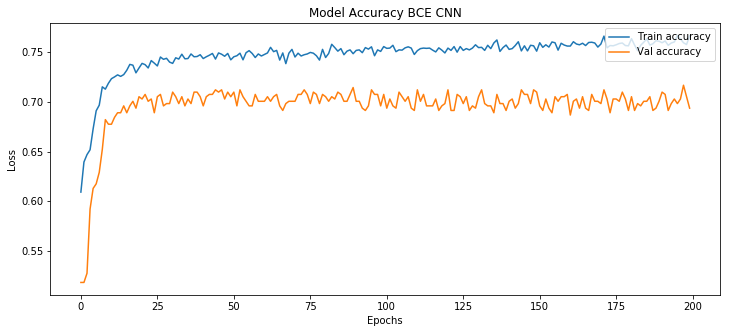

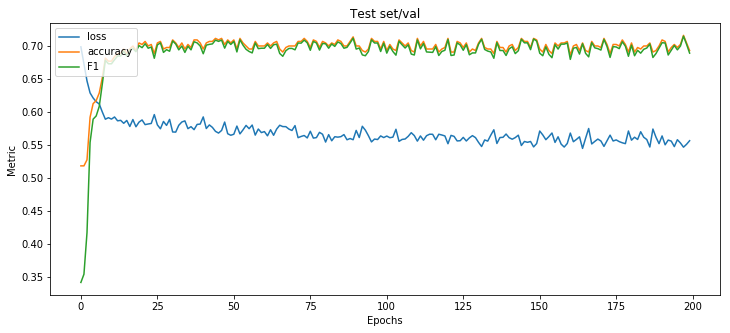

In [10]:
x_all=np.load("../obj4/LC_features/AE_300T_16D.npy")
x_train = x_all[mask_train]
x_val = x_all[mask_test]

if x_train.shape[0] < y_train.shape[0]:
    y_train = y_train[:x_train.shape[0]]
    
print ("Objetos de entrenamiento:",x_train.shape, y_train.shape)
print ("Objetos de validación:",x_val.shape,y_val.shape)

AE = Sequential()
AE.add(Dense(128, input_shape=x_train.shape[1:], activation='relu'))
AE.add(Dropout(0.5))
AE.add(Dense(1, activation='sigmoid'))

train_model(AE, x_train, y_train, x_val, y_val, e=200, BS=128, focal=False,alpha=0.6,save_f='./models/baseline_AE.hdf5')

,F1 macro,F1 micro,F1 raw,F1 weighted,Precision raw,Recall raw
False Positive,0.784099,0.800834,0.844209,0.80215,0.858921,0.829992
Confirmed,0.784099,0.800834,0.723988,0.80215,0.702665,0.746647


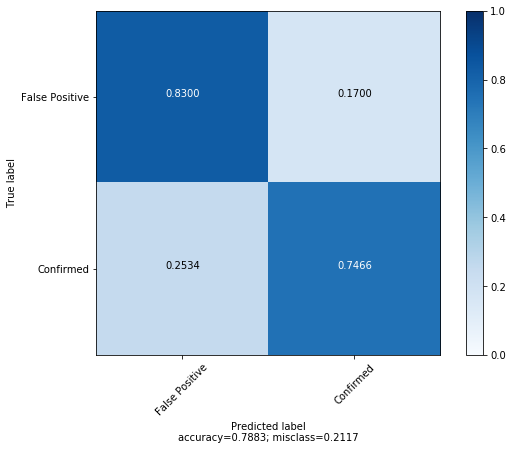

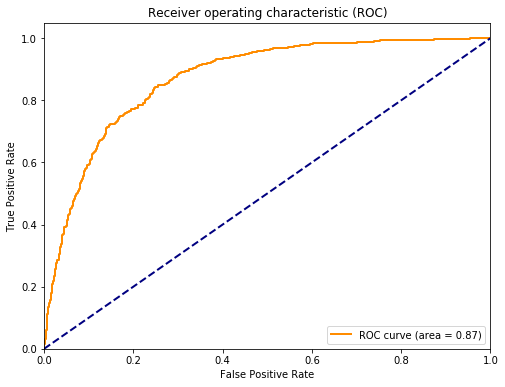

In [9]:
AE_loaded = keras.models.load_model("./models/baseline_AE.hdf5") #con 4 capas (64 y 128) con dropa en todo
#ff_loaded.summary()

predichos=AE_loaded.predict_classes(x_val)
calculate_metrics(y_val, predichos,'[VAL] Confusion Matrix 200 epochs - VAE') #con 3 capas aumentando/double

predichos_prob = AE_loaded.predict(x_val)
plot_ROC(y_val, predichos_prob) ##16

,F1 macro,F1 micro,F1 raw,F1 weighted,Precision raw,Recall raw
False Positive,0.728937,0.747654,0.800165,0.750328,0.824681,0.777065
Confirmed,0.728937,0.747654,0.657709,0.750328,0.625841,0.692996


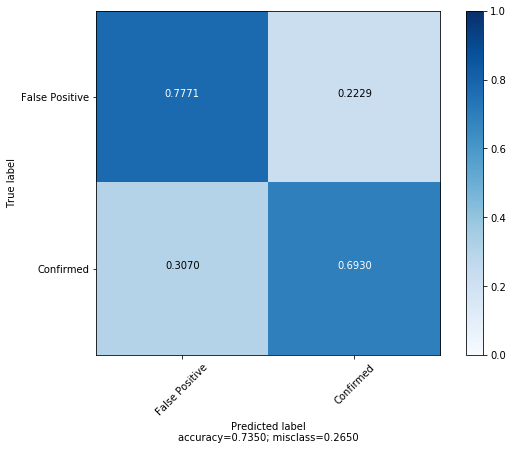

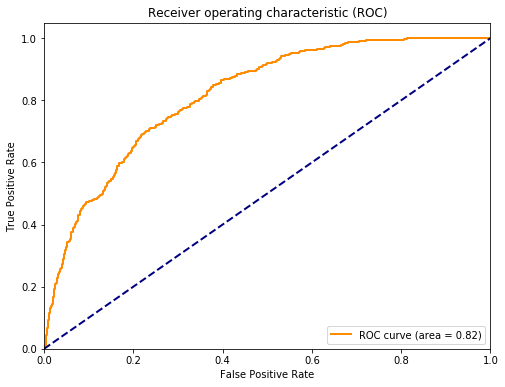

In [11]:
AE_loaded = keras.models.load_model("./models/baseline_AE.hdf5") #con 4 capas (64 y 128) con dropa en todo
#ff_loaded.summary()

predichos=AE_loaded.predict_classes(x_val)
calculate_metrics(y_val, predichos,'[VAL] Confusion Matrix 200 epochs - VAE') #con 3 capas aumentando/double

predichos_prob = AE_loaded.predict(x_val)
plot_ROC(y_val, predichos_prob) ##16

#### VAE 

Objetos de entrenamiento: (4339, 16) (4339,)
Objetos de validación: (1918, 16) (1918,)
Train on 3905 samples, validate on 434 samples
Epoch 1/200
3905/3905 [==============================] - 1s 217us/step - loss: 0.6023 - acc: 0.6335 - val_loss: 0.6237 - val_acc: 0.5092
 - val_f1: 0.341558 
Epoch 2/200
3905/3905 [==============================] - 0s 46us/step - loss: 0.5350 - acc: 0.6563 - val_loss: 0.5937 - val_acc: 0.6014
 - val_f1: 0.523987 
Epoch 3/200
3905/3905 [==============================] - 0s 46us/step - loss: 0.5109 - acc: 0.7211 - val_loss: 0.5630 - val_acc: 0.6959
 - val_f1: 0.672453 
Epoch 4/200
3905/3905 [==============================] - 0s 47us/step - loss: 0.4928 - acc: 0.7508 - val_loss: 0.5386 - val_acc: 0.7235
 - val_f1: 0.712741 
Epoch 5/200
3905/3905 [==============================] - 0s 47us/step - loss: 0.4828 - acc: 0.7721 - val_loss: 0.5220 - val_acc: 0.7535
 - val_f1: 0.746676 
Epoch 6/200
3905/3905 [==============================] - 0s 47us/step - loss: 0.

3905/3905 [==============================] - 0s 48us/step - loss: 0.3830 - acc: 0.8256 - val_loss: 0.4563 - val_acc: 0.7857
 - val_f1: 0.783385 
Epoch 53/200
3905/3905 [==============================] - 0s 47us/step - loss: 0.3867 - acc: 0.8279 - val_loss: 0.4554 - val_acc: 0.7811
 - val_f1: 0.778936 
Epoch 54/200
3905/3905 [==============================] - 0s 49us/step - loss: 0.3825 - acc: 0.8302 - val_loss: 0.4561 - val_acc: 0.7811
 - val_f1: 0.778508 
Epoch 55/200
3905/3905 [==============================] - 0s 48us/step - loss: 0.3885 - acc: 0.8246 - val_loss: 0.4527 - val_acc: 0.7834
 - val_f1: 0.781555 
Epoch 56/200
3905/3905 [==============================] - 0s 47us/step - loss: 0.3819 - acc: 0.8294 - val_loss: 0.4542 - val_acc: 0.7857
 - val_f1: 0.783590 
Epoch 57/200
3905/3905 [==============================] - 0s 48us/step - loss: 0.3862 - acc: 0.8256 - val_loss: 0.4525 - val_acc: 0.7834
 - val_f1: 0.781161 
Epoch 58/200
3905/3905 [==============================] - 0s 46us

3905/3905 [==============================] - 0s 55us/step - loss: 0.3743 - acc: 0.8343 - val_loss: 0.4506 - val_acc: 0.8018
 - val_f1: 0.800620 
Epoch 105/200
3905/3905 [==============================] - 0s 59us/step - loss: 0.3753 - acc: 0.8279 - val_loss: 0.4529 - val_acc: 0.7949
 - val_f1: 0.793429 
Epoch 106/200
3905/3905 [==============================] - 0s 59us/step - loss: 0.3681 - acc: 0.8366 - val_loss: 0.4514 - val_acc: 0.7926
 - val_f1: 0.791190 
Epoch 107/200
3905/3905 [==============================] - 0s 70us/step - loss: 0.3760 - acc: 0.8387 - val_loss: 0.4512 - val_acc: 0.7972
 - val_f1: 0.795830 
Epoch 108/200
3905/3905 [==============================] - 0s 65us/step - loss: 0.3712 - acc: 0.8394 - val_loss: 0.4519 - val_acc: 0.7949
 - val_f1: 0.793429 
Epoch 109/200
3905/3905 [==============================] - 0s 51us/step - loss: 0.3768 - acc: 0.8348 - val_loss: 0.4492 - val_acc: 0.7926
 - val_f1: 0.791190 
Epoch 110/200
3905/3905 [==============================] - 0

 - val_f1: 0.805256 
Epoch 156/200
3905/3905 [==============================] - 0s 46us/step - loss: 0.3698 - acc: 0.8397 - val_loss: 0.4475 - val_acc: 0.8065
 - val_f1: 0.805256 
Epoch 157/200
3905/3905 [==============================] - 0s 50us/step - loss: 0.3672 - acc: 0.8384 - val_loss: 0.4475 - val_acc: 0.8088
 - val_f1: 0.807644 
Epoch 158/200
3905/3905 [==============================] - 0s 49us/step - loss: 0.3594 - acc: 0.8438 - val_loss: 0.4480 - val_acc: 0.8041
 - val_f1: 0.802865 
Epoch 159/200
3905/3905 [==============================] - 0s 50us/step - loss: 0.3659 - acc: 0.8369 - val_loss: 0.4500 - val_acc: 0.8065
 - val_f1: 0.805256 
Epoch 160/200
3905/3905 [==============================] - 0s 50us/step - loss: 0.3637 - acc: 0.8446 - val_loss: 0.4474 - val_acc: 0.8088
 - val_f1: 0.807644 
Epoch 161/200
3905/3905 [==============================] - 0s 47us/step - loss: 0.3619 - acc: 0.8405 - val_loss: 0.4460 - val_acc: 0.8041
 - val_f1: 0.803009 
Epoch 162/200
3905/3905 [

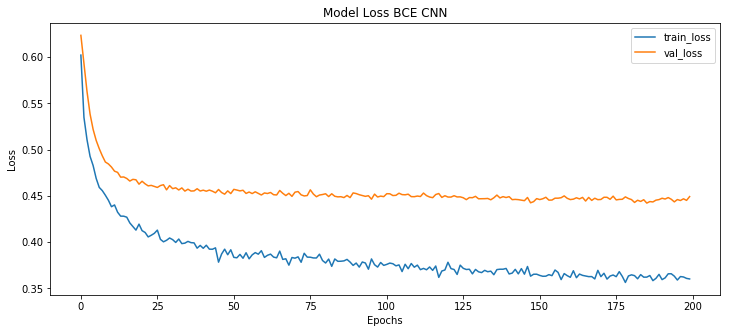

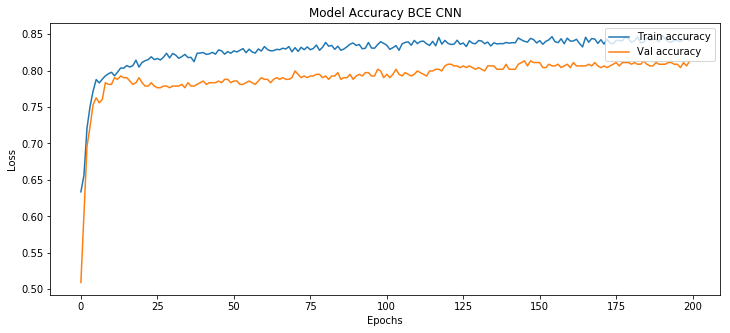

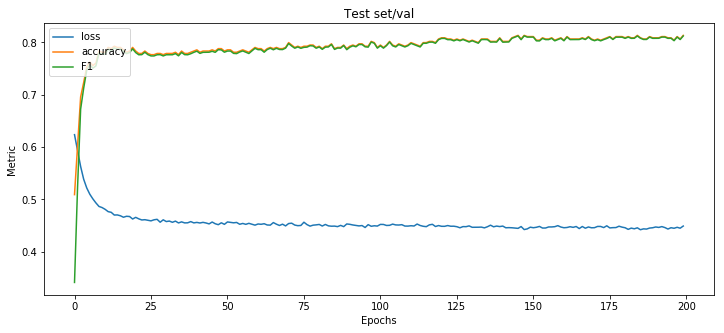

In [14]:
x_all=np.load("../obj4/LC_features/VAE_300T_16D.npy")
x_train = x_all[mask_train]
x_val = x_all[mask_test]

if x_train.shape[0] < y_train.shape[0]:
    y_train = y_train[:x_train.shape[0]]
    
print ("Objetos de entrenamiento:",x_train.shape, y_train.shape)
print ("Objetos de validación:",x_val.shape,y_val.shape)

VAE = Sequential()
VAE.add(Dense(128, input_shape=x_train.shape[1:], activation='relu'))
VAE.add(Dropout(0.5))
VAE.add(Dense(1, activation='sigmoid'))

train_model(VAE, x_train, y_train, x_val, y_val, e=200, BS=128, focal=False,alpha=0.6,save_f='./models/baseline_VAE.hdf5')

,F1 macro,F1 micro,F1 raw,F1 weighted,Precision raw,Recall raw
False Positive,0.798446,0.817518,0.860447,0.817066,0.855670,0.865277
Confirmed,0.798446,0.817518,0.736446,0.817066,0.744292,0.728763


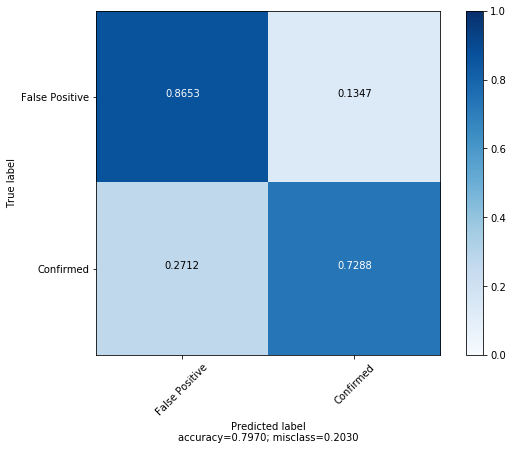

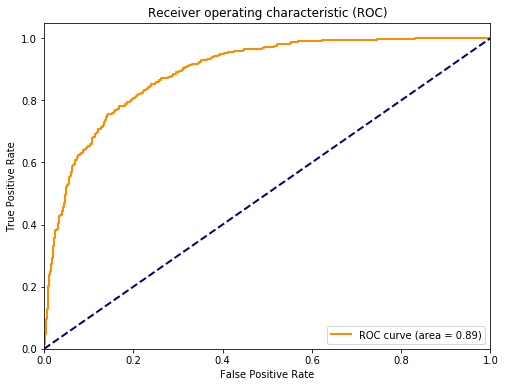

In [13]:
VAE_loaded = keras.models.load_model("./models/baseline_VAE.hdf5") #con 4 capas (64 y 128) con dropa en todo
#ff_loaded.summary()

predichos=VAE_loaded.predict_classes(x_val)
calculate_metrics(y_val, predichos,'[VAL] Confusion Matrix 200 epochs - VAE') #con 3 capas aumentando/double

predichos_prob = VAE_loaded.predict(x_val)
plot_ROC(y_val, predichos_prob)

,F1 macro,F1 micro,F1 raw,F1 weighted,Precision raw,Recall raw
False Positive,0.80357,0.819082,0.858771,0.820147,0.871901,0.846030
Confirmed,0.80357,0.819082,0.748368,0.820147,0.728814,0.769001


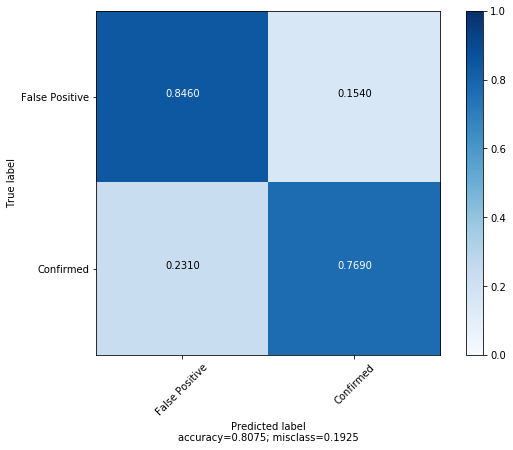

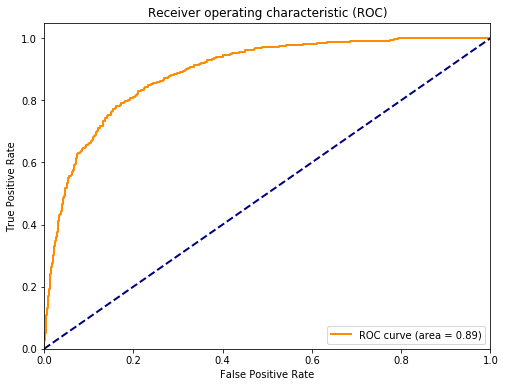

In [15]:
VAE_loaded = keras.models.load_model("./models/baseline_VAE.hdf5") #con 4 capas (64 y 128) con dropa en todo
#ff_loaded.summary()

predichos=VAE_loaded.predict_classes(x_val)
calculate_metrics(y_val, predichos,'[VAL] Confusion Matrix 200 epochs - VAE') #con 3 capas aumentando/double

predichos_prob = VAE_loaded.predict(x_val)
plot_ROC(y_val, predichos_prob) ##16

VAE sample no funciona bien..

#### VAE + escala

Objetos de entrenamiento: (4339, 16) (4339,)
Objetos de validación: (1918, 16) (1918,)
Train on 3905 samples, validate on 434 samples
Epoch 1/200
3905/3905 [==============================] - 1s 274us/step - loss: 0.5709 - acc: 0.7127 - val_loss: 0.5236 - val_acc: 0.7488
 - val_f1: 0.738333 
Epoch 2/200
3905/3905 [==============================] - 0s 54us/step - loss: 0.4558 - acc: 0.8046 - val_loss: 0.4605 - val_acc: 0.7903
 - val_f1: 0.785511 
Epoch 3/200
3905/3905 [==============================] - 0s 51us/step - loss: 0.4198 - acc: 0.8136 - val_loss: 0.4367 - val_acc: 0.8111
 - val_f1: 0.808089 
Epoch 4/200
3905/3905 [==============================] - 0s 51us/step - loss: 0.4033 - acc: 0.8210 - val_loss: 0.4261 - val_acc: 0.8180
 - val_f1: 0.815622 
Epoch 5/200
3905/3905 [==============================] - 0s 51us/step - loss: 0.3935 - acc: 0.8220 - val_loss: 0.4206 - val_acc: 0.8157
 - val_f1: 0.813386 
Epoch 6/200
3905/3905 [==============================] - 0s 52us/step - loss: 0.

3905/3905 [==============================] - 0s 50us/step - loss: 0.3365 - acc: 0.8428 - val_loss: 0.3724 - val_acc: 0.8295
 - val_f1: 0.828176 
Epoch 53/200
3905/3905 [==============================] - 0s 51us/step - loss: 0.3310 - acc: 0.8545 - val_loss: 0.3715 - val_acc: 0.8272
 - val_f1: 0.825782 
Epoch 54/200
3905/3905 [==============================] - 0s 48us/step - loss: 0.3352 - acc: 0.8461 - val_loss: 0.3681 - val_acc: 0.8272
 - val_f1: 0.825782 
Epoch 55/200
3905/3905 [==============================] - 0s 62us/step - loss: 0.3312 - acc: 0.8466 - val_loss: 0.3735 - val_acc: 0.8295
 - val_f1: 0.828032 
Epoch 56/200
3905/3905 [==============================] - 0s 50us/step - loss: 0.3372 - acc: 0.8435 - val_loss: 0.3658 - val_acc: 0.8318
 - val_f1: 0.830566 
Epoch 57/200
3905/3905 [==============================] - 0s 50us/step - loss: 0.3304 - acc: 0.8487 - val_loss: 0.3753 - val_acc: 0.8272
 - val_f1: 0.825476 
Epoch 58/200
3905/3905 [==============================] - 0s 49us

3905/3905 [==============================] - 0s 53us/step - loss: 0.3223 - acc: 0.8535 - val_loss: 0.3712 - val_acc: 0.8134
 - val_f1: 0.811845 
Epoch 105/200
3905/3905 [==============================] - 0s 49us/step - loss: 0.3228 - acc: 0.8530 - val_loss: 0.3709 - val_acc: 0.8180
 - val_f1: 0.816333 
Epoch 106/200
3905/3905 [==============================] - 0s 50us/step - loss: 0.3250 - acc: 0.8592 - val_loss: 0.3701 - val_acc: 0.8134
 - val_f1: 0.811845 
Epoch 107/200
3905/3905 [==============================] - 0s 52us/step - loss: 0.3220 - acc: 0.8586 - val_loss: 0.3627 - val_acc: 0.8180
 - val_f1: 0.816781 
Epoch 108/200
3905/3905 [==============================] - 0s 50us/step - loss: 0.3174 - acc: 0.8566 - val_loss: 0.3719 - val_acc: 0.8134
 - val_f1: 0.811845 
Epoch 109/200
3905/3905 [==============================] - 0s 51us/step - loss: 0.3251 - acc: 0.8528 - val_loss: 0.3653 - val_acc: 0.8157
 - val_f1: 0.814391 
Epoch 110/200
3905/3905 [==============================] - 0

 - val_f1: 0.816333 
Epoch 156/200
3905/3905 [==============================] - 0s 48us/step - loss: 0.3164 - acc: 0.8525 - val_loss: 0.3692 - val_acc: 0.8180
 - val_f1: 0.816490 
Epoch 157/200
3905/3905 [==============================] - 0s 48us/step - loss: 0.3141 - acc: 0.8540 - val_loss: 0.3651 - val_acc: 0.8180
 - val_f1: 0.816490 
Epoch 158/200
3905/3905 [==============================] - 0s 49us/step - loss: 0.3094 - acc: 0.8638 - val_loss: 0.3644 - val_acc: 0.8203
 - val_f1: 0.818888 
Epoch 159/200
3905/3905 [==============================] - 0s 50us/step - loss: 0.3137 - acc: 0.8617 - val_loss: 0.3699 - val_acc: 0.8157
 - val_f1: 0.813926 
Epoch 160/200
3905/3905 [==============================] - 0s 50us/step - loss: 0.3119 - acc: 0.8584 - val_loss: 0.3651 - val_acc: 0.8226
 - val_f1: 0.821282 
Epoch 161/200
3905/3905 [==============================] - 0s 51us/step - loss: 0.3005 - acc: 0.8650 - val_loss: 0.3670 - val_acc: 0.8203
 - val_f1: 0.818577 
Epoch 162/200
3905/3905 [

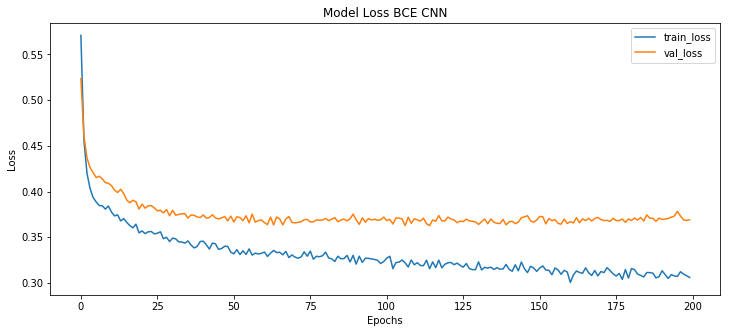

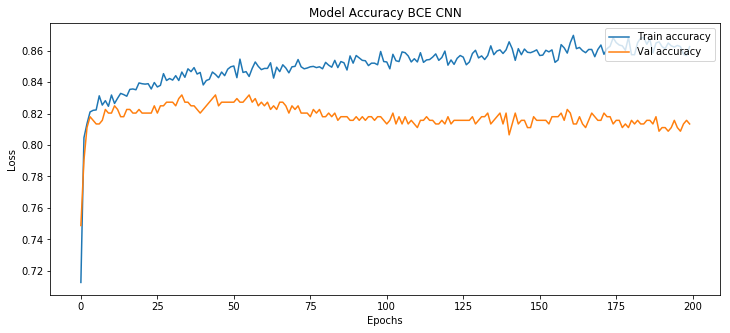

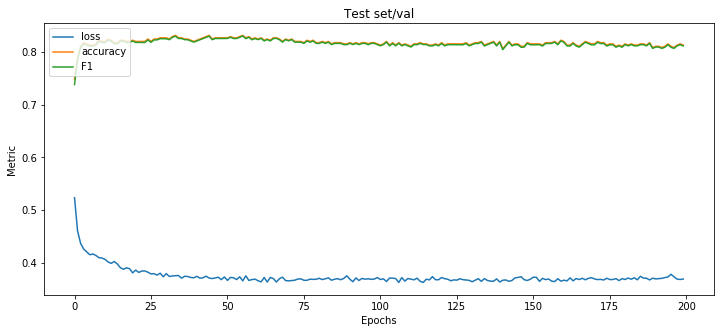

In [18]:
x_all=np.load("../obj4/LC_features/VAE_S_300T_16D.npy")
#x_all2=np.load("../obj4/LC_features/VAE_S_300T_32D_var.npy")
#x_all = np.concatenate([x_all,x_all2], axis=-1)

x_train = x_all[mask_train]
x_val = x_all[mask_test]

if x_train.shape[0] < y_train.shape[0]:
    y_train = y_train[:x_train.shape[0]]
    
print ("Objetos de entrenamiento:",x_train.shape, y_train.shape)
print ("Objetos de validación:",x_val.shape,y_val.shape)

VAEs = Sequential()
VAEs.add(Dense(128, input_shape=x_train.shape[1:], activation='relu'))
VAEs.add(Dropout(0.5))
VAEs.add(Dense(1, activation='sigmoid'))

train_model(VAEs, x_train, y_train, x_val, y_val, e=200, BS=128, focal=False,alpha=0.6,save_f='./models/baseline_VAEs.hdf5')

,F1 macro,F1 micro,F1 raw,F1 weighted,Precision raw,Recall raw
False Positive,0.821049,0.834202,0.869565,0.835619,0.890008,0.850040
Confirmed,0.821049,0.834202,0.772532,0.835619,0.742779,0.804769


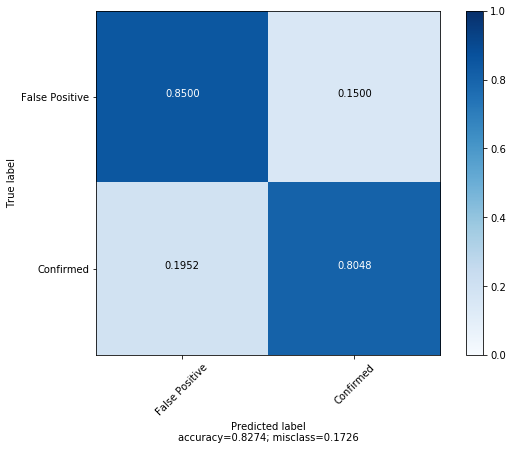

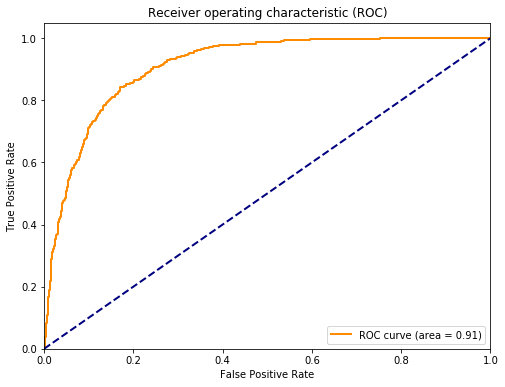

In [17]:
VAEs_loaded = keras.models.load_model("./models/baseline_VAEs.hdf5") #con 4 capas (64 y 128) con dropa en todo
#ff_loaded.summary()

predichos=VAEs_loaded.predict_classes(x_val)
calculate_metrics(y_val, predichos,'[VAL] Confusion Matrix 200 epochs - VAE sample') #con 3 capas aumentando/double

predichos_prob = VAEs_loaded.predict(x_val)
plot_ROC(y_val, predichos_prob) #S

#### VAE + escala --> 16

,F1 macro,F1 micro,F1 raw,F1 weighted,Precision raw,Recall raw
False Positive,0.826463,0.839416,0.873874,0.840701,0.892887,0.855654
Confirmed,0.826463,0.839416,0.779053,0.840701,0.751037,0.809240


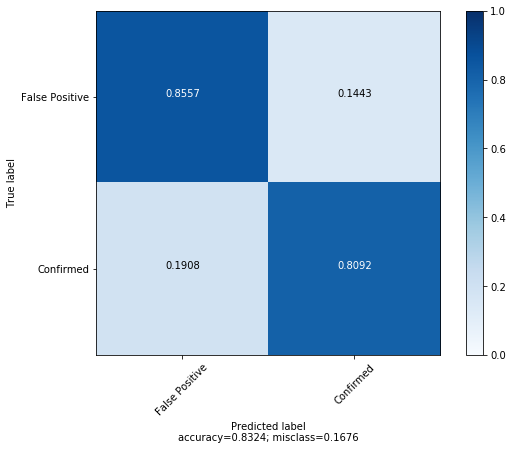

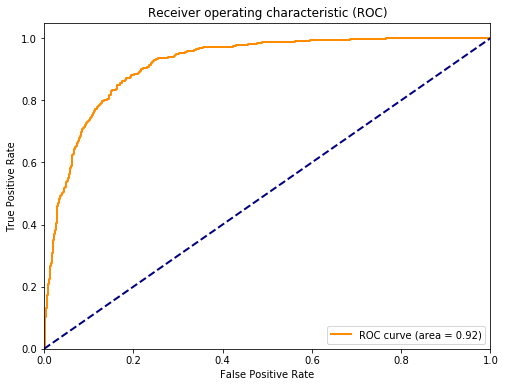

In [20]:
VAEs_loaded = keras.models.load_model("./models/baseline_VAEs.hdf5") #con 4 capas (64 y 128) con dropa en todo
#ff_loaded.summary()

predichos=VAEs_loaded.predict_classes(x_val)
calculate_metrics(y_val, predichos,'[VAL] Confusion Matrix 200 epochs - VAE sample') #con 3 capas aumentando/double

predichos_prob = VAEs_loaded.predict(x_val)
plot_ROC(y_val, predichos_prob)

|Técnicas     |F1-macro| 
|---          |---     |
|Metadata     | 87.13  |
|--- |---|
|Feets|???|
|Fou+PCA(32)  | 69.29  |
|Fou+PCA(MTF) | 68.68  |
| CNN-deep (LC) *   | ??  |
| **CNN (MTF)**   | 76.93  |
| **CNN-deep (MTF)**   | gabo  |

(*) C. Aguirre (2018) a estrellas variables

|Técnicas         |F1-macro| 
|---              |---     |
|--- |---|
|Fold-Glo(300)    | 77.57  |
|--- |---|
| AE (32)         | 79.10  |
| **VAE (32)**    | 79.84  |
|**VAE-scale(32)**| 82.10  | 
| AE (16)         | 75.18  |
| **VAE (16)**    | 80.36  |
|**VAE-scale(16)**| 82.65  | 
|Shallue CNN(Fold)| ??     |